In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('filled_missings_df.csv')

In [3]:
df.head()

,Unnamed: 0,ListingKey,ListingNumber,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,ListingCategory (numeric),...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,0,1021339766868145413AB3B,193129,13751.0,36,Completed,0.16516,0.1580,0.1380,0,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258,0
1,1,10273602499503308B223C1,1209647,16128.0,36,Current,0.12016,0.0920,0.0820,2,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1,0
2,2,0EE9337825851032864889A,81716,13518.0,36,Completed,0.28269,0.2750,0.2400,0,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41,0
3,3,0EF5356002482715299901A,658116,15635.0,36,Current,0.12528,0.0974,0.0874,16,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158,0
4,4,0F023589499656230C5E3E2,909464,15962.0,36,Current,0.24614,0.2085,0.1985,2,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20,0


In [82]:
df.columns

Index(['Unnamed: 0', 'ListingKey', 'ListingNumber', 'ListingCreationDate',
       'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'BorrowerState', 'EmploymentStatus',
       'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'Loa

### All those should be droppedd if we assume that we are making a model focused on scoring clients before giving them a loan

In [4]:
cols_to_drop = ['Unnamed: 0', 'ListingKey', 'ListingNumber', 'LoanStatus', 'LoanKey', 'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination', 'LoanNumber',
                'MemberKey', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
                'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'LoanOriginationDate', 'LoanOriginationQuarter',
                'FirstRecordedCreditLine', 'CreditScoreRangeLower', 'CreditScoreRangeUpper']

In [5]:
df = df.drop(columns=cols_to_drop)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114805 entries, 0 to 114804
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ListingCreationDate                 114413 non-null  float64
 1   Term                                114805 non-null  int64  
 2   BorrowerAPR                         114805 non-null  float64
 3   BorrowerRate                        114805 non-null  float64
 4   LenderYield                         114805 non-null  float64
 5   ListingCategory (numeric)           114805 non-null  int64  
 6   BorrowerState                       114805 non-null  object 
 7   EmploymentStatus                    114805 non-null  object 
 8   EmploymentStatusDuration            114805 non-null  float64
 9   IsBorrowerHomeowner                 114805 non-null  int64  
 10  CurrentlyInGroup                    114805 non-null  int64  
 11  DateCreditPulled          

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101)

#### Binning with optbin
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#what_is_weight_of_evidence

In [10]:
from optbinning import OptimalBinning

y_train = train_df["Defaulted"]
X_train = train_df.drop(columns=["Defaulted"])
X_test = test_df.copy()

binning_transformers = {}
X_train_binned = pd.DataFrame()
X_test_binned = pd.DataFrame()
X_train_binned_woe = pd.DataFrame()
X_test_binned_woe = pd.DataFrame()
all_woe_rows = []
iv_scores = {}

def is_binary(series):
    return set(series.dropna().unique()) <= {0, 1}


for column in X_train.columns:
    # Define variable type
    if is_binary(X_train[column]):
        dtype = "categorical"
    elif pd.api.types.is_numeric_dtype(X_train[column]):
        dtype = "numerical"
    else:
        dtype = "categorical"

    # Fit binning
    optb = OptimalBinning(name=column, dtype=dtype, solver="cp", max_n_bins=3)
    optb.fit(X_train[column], y_train)
    binning_transformers[column] = optb

    # Transform to WOE and bins
    X_train_binned_woe[column] = -optb.transform(X_train[column], metric="woe")
    X_test_binned_woe[column] = -optb.transform(X_test[column], metric="woe")
    X_train_binned[column] = optb.transform(X_train[column], metric="bins")
    X_test_binned[column] = optb.transform(X_test[column], metric="bins")

    # Build binning table and extract WOE info
    binning_table_df = optb.binning_table.build()
    iv_scores[column] = float(optb.binning_table.iv)

    # Add variable name and IV to each row, then store
    binning_table_df["Variable"] = column
    binning_table_df["IV"] = iv_scores[column]
    all_woe_rows.append(binning_table_df[["Variable", "Bin", "Count", "Event rate", "WoE", "IV"]])


all_woe_combined = pd.concat(all_woe_rows, ignore_index=True)


all_woe_combined.to_excel("woe_all_variables.xlsx", index=False)


print(all_woe_combined.head())

              Variable                   Bin  Count  Event rate       WoE  \
0  ListingCreationDate      (-inf, 15655.50)  51682    0.253144 -0.669577   
1  ListingCreationDate  [15655.50, 15985.50)  19679    0.022816  2.005714   
2  ListingCreationDate       [15985.50, inf)  20176    0.000099  7.467513   
3  ListingCreationDate               Special      0    0.000000       0.0   
4  ListingCreationDate               Missing    307    0.149837 -0.015611   

         IV  
0  2.665137  
1  2.665137  
2  2.665137  
3  2.665137  
4  2.665137  


### Feature Selection

#### Information Values

In [11]:
iv_scores

{'ListingCreationDate': 2.6651367514017514,
 'Term': 0.21787231563493004,
 'BorrowerAPR': 0.2702199551901524,
 'BorrowerRate': 0.3814228828411286,
 'LenderYield': 0.370926816899894,
 'ListingCategory (numeric)': 0.4905577648612991,
 'BorrowerState': 0.057466611966100714,
 'EmploymentStatus': 0.7221310333251305,
 'EmploymentStatusDuration': 0.20193232382262077,
 'IsBorrowerHomeowner': 0.015376850894377861,
 'CurrentlyInGroup': 0.2876375490102512,
 'DateCreditPulled': 0.8601452576489081,
 'OpenCreditLines': 0.23307609382985228,
 'TotalCreditLinespast7years': 0.0621598421802579,
 'OpenRevolvingAccounts': 0.22998115905344196,
 'OpenRevolvingMonthlyPayment': 0.2788728145059118,
 'InquiriesLast6Months': 0.39054080235822125,
 'TotalInquiries': 0.3649246619566935,
 'CurrentDelinquencies': 0.28100265996741525,
 'AmountDelinquent': 0.07296320689888242,
 'DelinquenciesLast7Years': 0.08675256993848861,
 'PublicRecordsLast10Years': 0.019378897017317903,
 'PublicRecordsLast12Months': 0.0,
 'Revolvin

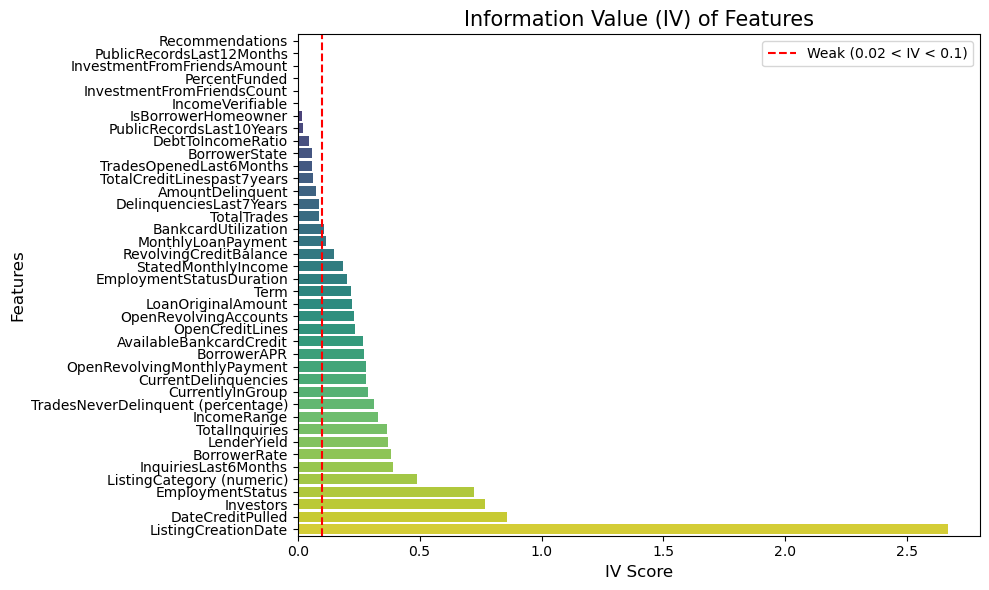

In [12]:
iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=iv_df.index, data=iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.02, color='red', linestyle='--', label='Not useful (IV < 0.02)')
plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')
# plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak (0.02 < IV < 0.1)')
# plt.axvline(x=0.3, color='yellow', linestyle='--', label='Medium (0.1 < IV < 0.3)')
# plt.axvline(x=0.5, color='green', linestyle='--', label='Strong (0.3 < IV < 0.5)')
# # plt.axvline(x=0.505, color='red', linestyle='--', label='Too high (0.5 < IV)')
plt.legend()

plt.tight_layout()
plt.show()

#### Variable predictivness

In [ ]:
# no_prediction_power = [] # to be removed
# weak_prediction_power = []
# medium_predictive_power = []
# strong_predictive_power = []
# too_big_predictive_power = [] # to be removed

# for key, value in iv_scores.items():
#     if value < 0.02:
#         no_prediction_power += [key]
#     elif value <= 0.1:
#         weak_prediction_power += [key]
#     elif value <= 0.3:
#         medium_predictive_power += [key]
#     elif value <= 0.5:
#         strong_predictive_power += [key]
#     else:
#         too_big_predictive_power += [key]

In [13]:
no_prediction_power = [] # to be removed
good_prediction_power = []

for key, value in iv_scores.items():
    if value <= 0.1:
        no_prediction_power += [key]
    else:
        good_prediction_power += [key]

In [14]:
print(*good_prediction_power, sep='\n')

ListingCreationDate
Term
BorrowerAPR
BorrowerRate
LenderYield
ListingCategory (numeric)
EmploymentStatus
EmploymentStatusDuration
CurrentlyInGroup
DateCreditPulled
OpenCreditLines
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TradesNeverDelinquent (percentage)
IncomeRange
StatedMonthlyIncome
LoanOriginalAmount
MonthlyLoanPayment
Investors


#### Lasso Regression for feature selection

In [15]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_binned_woe)
X_test_scaled = scaler.transform(X_test_binned_woe)

lasso = LassoCV(
    alphas=np.logspace(-3, 0, 50),
    cv=5, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

selected_lasso = X_train_binned_woe.columns[lasso.coef_ != 0].tolist()
print("Selected features by Lasso:")
print(*selected_lasso, sep='\n')

Selected features by Lasso:
ListingCreationDate
Term
BorrowerAPR
BorrowerRate
LenderYield
ListingCategory (numeric)
BorrowerState
EmploymentStatus
IsBorrowerHomeowner
CurrentlyInGroup
DateCreditPulled
OpenCreditLines
TotalCreditLinespast7years
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
AmountDelinquent
DelinquenciesLast7Years
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TotalTrades
TradesNeverDelinquent (percentage)
TradesOpenedLast6Months
DebtToIncomeRatio
IncomeRange
IncomeVerifiable
StatedMonthlyIncome
LoanOriginalAmount
MonthlyLoanPayment
Investors


In [16]:
print(*[(x, x in good_prediction_power, iv_scores[x]) for x in selected_lasso], sep='\n')

('ListingCreationDate', True, 2.6651367514017514)
('Term', True, 0.21787231563493004)
('BorrowerAPR', True, 0.2702199551901524)
('BorrowerRate', True, 0.3814228828411286)
('LenderYield', True, 0.370926816899894)
('ListingCategory (numeric)', True, 0.4905577648612991)
('BorrowerState', False, 0.057466611966100714)
('EmploymentStatus', True, 0.7221310333251305)
('IsBorrowerHomeowner', False, 0.015376850894377861)
('CurrentlyInGroup', True, 0.2876375490102512)
('DateCreditPulled', True, 0.8601452576489081)
('OpenCreditLines', True, 0.23307609382985228)
('TotalCreditLinespast7years', False, 0.0621598421802579)
('OpenRevolvingAccounts', True, 0.22998115905344196)
('OpenRevolvingMonthlyPayment', True, 0.2788728145059118)
('InquiriesLast6Months', True, 0.39054080235822125)
('TotalInquiries', True, 0.3649246619566935)
('CurrentDelinquencies', True, 0.28100265996741525)
('AmountDelinquent', False, 0.07296320689888242)
('DelinquenciesLast7Years', False, 0.08675256993848861)
('RevolvingCreditBala

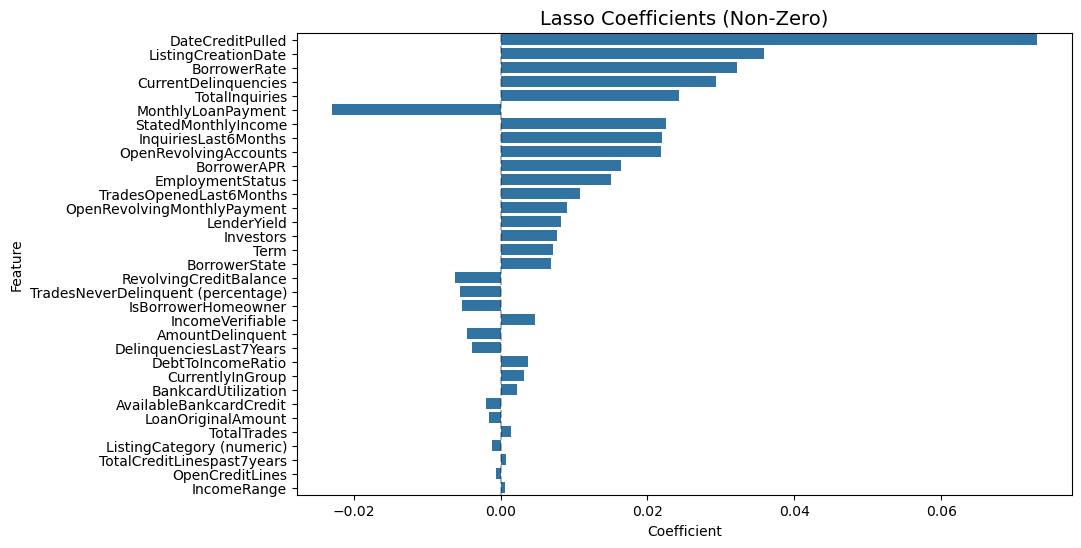

In [17]:
coef_df = pd.DataFrame({
    'Feature': X_train_binned_woe.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df[coef_df['Coefficient'] != 0])
plt.title('Lasso Coefficients (Non-Zero)', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

In [18]:
print("Optimal lambda (alpha):", lasso.alpha_)

Optimal lambda (alpha): 0.001


In [112]:
selected_iv = good_prediction_power

final_features = list(set(selected_iv) & set(selected_lasso))
print("Final selected features (IV + Lasso):")
print(*final_features, sep='\n')
# print(*[(x, iv_scores[x]) for x in final_features], sep='\n')

Final selected features (IV + Lasso):
ListingCategory (numeric)
CurrentDelinquencies
OpenRevolvingAccounts
BorrowerRate
OpenRevolvingMonthlyPayment
InquiriesLast6Months
RevolvingCreditBalance
EmploymentStatus
CurrentlyInGroup
Investors
StatedMonthlyIncome
EmploymentStatusDuration
AvailableBankcardCredit
BankcardUtilization
TotalInquiries
Term
MonthlyLoanPayment
BorrowerAPR


In [113]:
final_iv_scores = {key: iv_scores[key] for key in final_features}

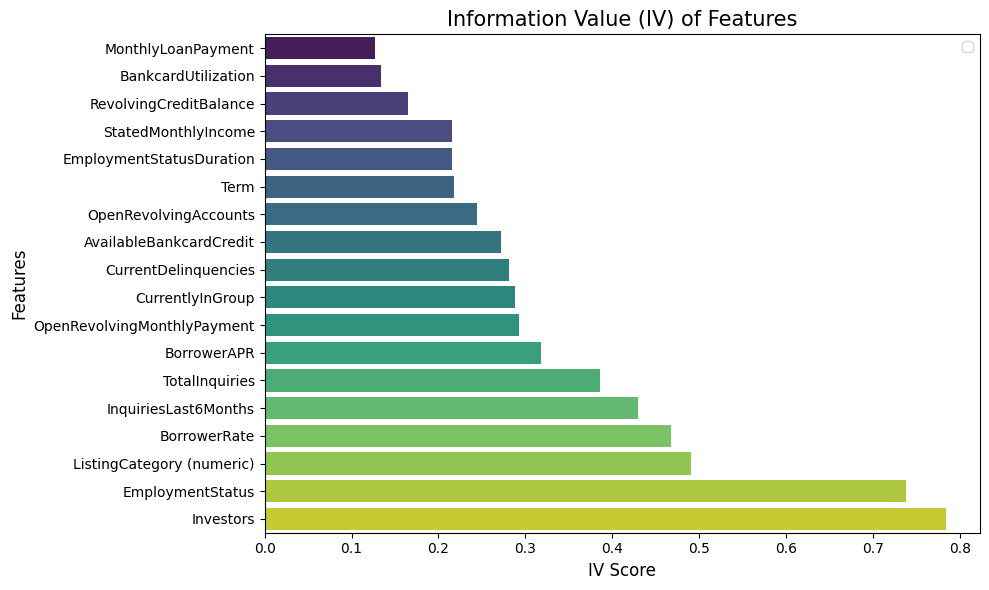

In [114]:
final_iv_df = pd.DataFrame.from_dict(final_iv_scores, orient='index', columns=['IV'])
final_iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=final_iv_df.index, data=final_iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')
plt.legend()

plt.tight_layout()
plt.show()

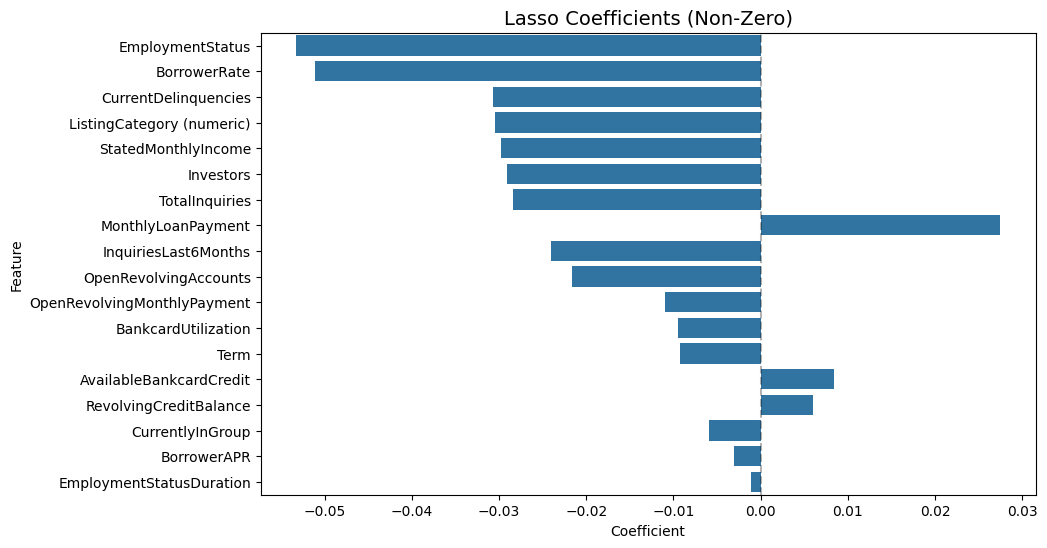

In [117]:
final_coef = coef_df[coef_df['Feature'].isin(final_features)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=final_coef)
plt.title('Lasso Coefficients (Non-Zero)', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

### TODO: 
1. *Information Value - done*
2. Lasso regression
3. Maybe random forest and based on feature importance
4. Also maybe combine 1 and 2 and 3, so if IV is high (maybe above ~ 0.03) and coefficient non zero and decent feature importance 